In [108]:
import xarray as xr
import numpy as np
import pandas as pd
import float_data_processing as fl
import glob, os
import matplotlib.pyplot as plt
from scipy import interpolate
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import O2sol

In [3]:

# Set the paths
plot_dir = '../plots/'


# Check for a glodap_offsets_plots directory, create if it does not exist
data_dir = '../data/'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)



In [4]:
gdap = fl.get_glodap(data_dir, year = 2022)
gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
#set flagged data to NaN (is this needed? or masked array better?)
flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0']

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap[v][naninds] = np.nan

# GLODAP derived variables: density, MLD and pH

#calc potential density
# gdap['sigma0_calculated'] = carbon_utils.sigma0(gdap.G2salinity.values,gdap.G2temperature.values,
#                                   gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)
# #calculate spice
# gdap['spice'] = carbon_utils.spiciness0(gdap.G2salinity.values,gdap.G2temperature.values,
#                                   gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)

#rename GLODAP comparison variables to match argo
gdap = gdap.rename(columns={'G2longitude':'LONGITUDE', 'G2latitude':'LATITUDE', 'G2pressure':'PRES_ADJUSTED',
                            'G2temperature':'TEMP_ADJUSTED','G2salinity':'PSAL_ADJUSTED', 
                            'G2oxygen':'DOXY_ADJUSTED','G2nitrate':'NITRATE_ADJUSTED', 'G2tco2':'DIC', 
                            'G2talk':'TALK_LIAR', 'G2MLD':'MLD','G2o2sat':'o2sat', 'G2PTMP':'PTMP', 
                            'sigma0_calculated':'PDENS'})

gdap['obs_index']=gdap.reset_index().index

https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0257247/GLODAPv2.2022_Merged_Master_File.csv


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Projects/2023_12 Bubble_Flux_Parameterization_Deike/code/float_data_processing.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdap = pd.read_csv(save_dir+'GLODAPv2.'+str(year)+'_Merged_Master_File.csv')
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/1226971315.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/1226971315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [26]:
surface_index = gdap.PRES_ADJUSTED<10

gdap_surf = gdap[surface_index]
# len(gdap_surf)
nh_month_check = (gdap_surf.datetime.dt.month >= 8) | (gdap_surf.datetime.dt.month <= 3)
nh_winter_index = np.logical_and(nh_month_check, gdap_surf.LATITUDE>=0)

sh_month_check = (gdap_surf.datetime.dt.month >= 4) & (gdap_surf.datetime.dt.month <= 10)
sh_winter_index = np.logical_and(sh_month_check, gdap_surf.LATITUDE<0)
gdap_winter = gdap_surf[np.logical_and(np.logical_or(nh_winter_index, sh_winter_index), ~np.isnan(gdap_surf.DOXY_ADJUSTED))]
gdap_winter['G2expocode'] = gdap_winter['G2expocode'].astype(str) # need to force all expocodes to be strings

gdap_winter_expo = (np.unique(gdap_winter.G2expocode.values))

gdap_winter['DOXY_SAT'] = O2sol.O2sol(gdap_winter.PSAL_ADJUSTED, gdap_winter.TEMP_ADJUSTED)
gdap_winter['DELTA_O2'] = gdap_winter.DOXY_ADJUSTED - gdap_winter.DOXY_SAT


77481

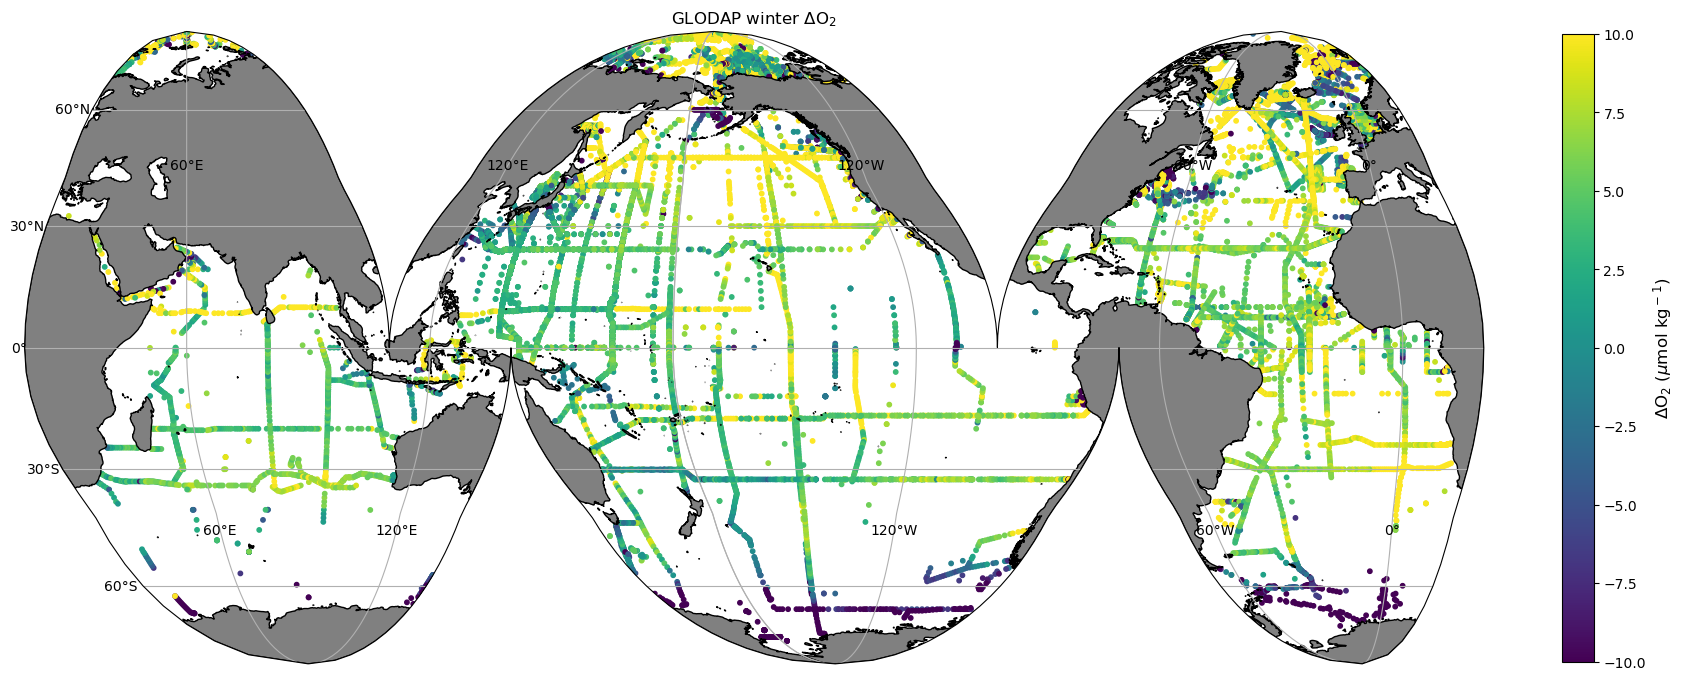

In [90]:
# Plot of winter delta O2 measurements from GLODAP
fig = plt.figure(figsize=(17, 12))
# gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1])
# fig, axs = plt.subplot_mosaic([['a.', 'b.'],['c.','d.'],['e.','f.']], layout='constrained', figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = fig.add_subplot(1,1,1, projection=ccrs.InterruptedGoodeHomolosine(central_longitude=-160, globe=None, emphasis='ocean'))
        
# [fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree()), 
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor=[.5, .5 ,.5]))

# ax.coastlines()
ax.set_global()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False

# # Oxygen offset
sct = ax.scatter(gdap_winter.LONGITUDE, gdap_winter.LATITUDE, 10,gdap_winter.DELTA_O2, vmin=-10, vmax=10, transform=ccrs.PlateCarree())

# cbar = plt.colorbar(sct)
cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=.02)#, fraction=0.1, aspect=40, pad=0.08)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$\Delta$O$_2$ ($\mu$mol kg$^-$$^1$)', size=12)


plt.title('GLODAP winter $\Delta$O$_2$')

plt.tight_layout()

In [107]:
type(gdap_winter_mean)

pandas.core.frame.DataFrame

In [115]:
# save out table of cruise expocode, mean dates, lat/lon

#convert datetime to numberic for mean calculation:
gdap_winter['datetime_numeric'] = gdap_winter['datetime'].astype(int)  

gdap_winter_g = gdap_winter.groupby(gdap_winter.G2expocode)


gdap_winter_meta = gdap_winter_g.median()

#convert back to datetime
gdap_winter_meta['datetime_median'] = pd.to_datetime(gdap_winter_mean['datetime_numeric'], unit='ns')

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/3787506454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap_winter['datetime_numeric'] = gdap_winter['datetime'].astype(int)
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_61628/3787506454.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdap_winter_mean = gdap_winter_g.median()


,G2cruise,G2station,G2region,G2cast,G2year,G2month,G2day,G2hour,G2minute,LATITUDE,...,G2donf,G2tdn,G2tdnf,G2chla,G2chlaf,obs_index,DOXY_SAT,DELTA_O2,datetime_numeric,datetime_mean
G2expocode,,,,,,,,,,,,,,,,,,,,,
06AQ19840719,1.0,376.0,4.0,1.0,1984.0,8.0,3.0,12.5,29.5,77.6585,...,9.0,-9999.0,9.0,-9999.0,9.0,602.0,304.086222,17.212780,4.603945e+17,1984-08-03 15:22:00
06AQ19860627,2.0,306.0,1.0,1.0,1986.0,8.0,19.5,0.0,0.0,-65.3515,...,9.0,-9999.0,9.0,-9999.0,9.0,1489.5,362.619541,-47.425539,5.235408e+17,1986-08-04 12:00:00
06AQ19870704,3.0,372.0,4.0,1.0,1987.0,8.0,6.0,15.0,27.0,86.1380,...,9.0,-9999.0,9.0,-9999.0,9.0,4487.0,366.366660,20.333340,5.552620e+17,1987-08-06 15:27:00
06AQ19890906,4.0,159.0,1.0,1.0,1989.0,9.0,12.0,14.0,26.0,-64.9500,...,9.0,-9999.0,9.0,-9999.0,9.0,5223.0,362.803132,-61.289251,6.224165e+17,1989-09-21 21:28:00
06AQ19920521,6.0,610.5,1.0,1.0,1992.0,6.0,16.0,11.0,29.0,-64.9830,...,9.0,-9999.0,9.0,-9999.0,9.0,9814.5,363.561918,-47.232113,7.098910e+17,1992-06-30 07:57:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90JS20080815,716.0,59.0,4.0,1.0,2008.0,9.0,9.0,0.0,0.0,73.1920,...,9.0,-9999.0,9.0,-9999.0,9.0,989013.0,358.214762,8.191601,1.220746e+18,2008-09-07 00:00:00
CARBOGIB2005,719.0,27.0,1.0,1.0,2006.0,3.0,21.0,0.0,0.0,35.9110,...,9.0,-9999.0,9.0,-9999.0,9.0,992487.0,233.143909,12.886091,1.142899e+18,2006-03-21 00:00:00
IcelandSea,720.0,440080.0,4.0,1.0,1997.0,8.0,17.0,12.0,0.0,68.0000,...,9.0,-9999.0,9.0,-9999.0,9.0,993451.5,329.027029,-1.230130,8.562060e+17,1997-02-17 19:00:00


In [113]:
selected_cols = ['G2cruise', 'datetime_median', 'G2year', 'G2month', 'LATITUDE', 'LONGITUDE']

In [114]:
gdap_winter_out = gdap_winter_meta[selected_cols]
print(gdap_winter_out)
gdap_winter_out.to_csv(data_dir + 'GLODAP_WINTER_CRUISE_metadata.csv', index_label='G2expocode')

              G2cruise                 datetime_mean
G2expocode                                          
06AQ19840719       1.0 1984-08-03 12:48:00.000000000
06AQ19860627       2.0 1986-08-07 08:43:38.181818176
06AQ19870704       3.0 1987-08-06 15:27:00.000000000
06AQ19890906       4.0 1989-09-22 14:09:45.454545408
06AQ19920521       6.0 1992-07-02 02:38:28.333333376
...                ...                           ...
90JS20080815     716.0 2008-09-06 01:36:00.000000000
CARBOGIB2005     719.0 2006-03-21 00:00:00.000000000
IcelandSea       720.0 1998-10-14 03:19:14.262295040
IrmingerSea      721.0 1997-01-28 08:33:26.956521728
OMEX2            723.0 1999-02-13 05:17:38.823529472

[600 rows x 2 columns]


In [93]:
gdap_winter_mean

,G2cruise,G2station,G2region,G2cast,G2year,G2month,G2day,G2hour,G2minute,LATITUDE,...,G2docf,G2don,G2donf,G2tdn,G2tdnf,G2chla,G2chlaf,obs_index,DOXY_SAT,DELTA_O2
G2expocode,,,,,,,,,,,,,,,,,,,,,
06AQ19840719,1.0,374.642857,4.0,1.071429,1984.000000,8.000000,3.000000,12.357143,26.571429,77.542714,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,590.142857,319.288732,19.082696
06AQ19860627,2.0,306.863636,1.0,1.318182,1986.000000,7.681818,17.227273,0.000000,0.000000,-64.764227,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,1547.545455,362.618222,-48.478222
06AQ19870704,3.0,372.000000,4.0,1.000000,1987.000000,8.000000,6.000000,15.000000,27.000000,86.138000,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,4487.000000,366.366660,20.333340
06AQ19890906,4.0,159.424242,1.0,1.000000,1989.000000,9.303030,12.939394,13.000000,26.121212,-65.367697,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,5268.000000,362.026698,-55.259291
06AQ19920521,6.0,612.472222,1.0,1.500000,1992.000000,6.444444,18.277778,11.527778,26.805556,-64.798139,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,9830.027778,363.405363,-44.124808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90JS20080815,716.0,63.250000,4.0,1.000000,2008.000000,8.816667,11.750000,0.000000,0.000000,73.388058,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,989058.000000,357.042568,5.552432
CARBOGIB2005,719.0,27.000000,1.0,1.000000,2006.000000,3.000000,21.000000,0.000000,0.000000,35.911000,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,992487.000000,233.143909,12.886091
IcelandSea,720.0,489398.163934,4.0,1.000000,1998.229508,7.131148,16.557377,11.393443,11.368852,67.992074,...,9.0,-9999.0,9.0,-9999.0,9.0,-9999.0,9.0,993505.639344,322.006415,0.761618
